# Natural Language Processing with Disaster Tweets

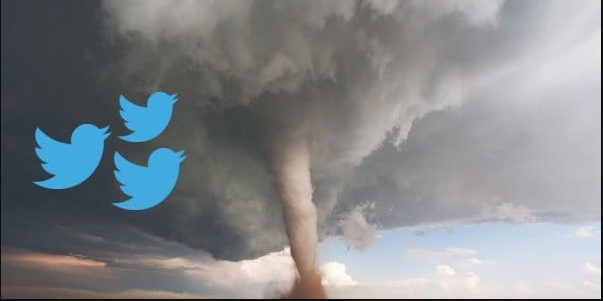

In this notebook we are going to predict whether a Twitter tweet is about a real occuring disaster or it isn't. For further explanation check out the Kaggle Competition Description. https://www.kaggle.com/c/nlp-getting-started 

**Best results: 80.05% (f1 score)**

# Agenda📃:
1. First Look
2. Data Cleaning and Text Preprocessing
3. Data Exploration
4. Base Model
* 4.1 Bag of Words Model
* 4.2 Embedding Model
* 4.3 Meta Features Model
5. Stacked Model
6. Submission


In [ ]:
 # linear algebra
import numpy as np
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
#data loading
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
#visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
#train and test set
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# 1. First Look🔎

Our Data doesn't seem too complicated. With just a hand full of features we mainly will focus on the text processing and evaluation part.

In [ ]:
#overview
train.head()

In [ ]:
#shape
print("Training set shape: {}".format(train.shape))
print("Test set shape: {}".format(test.shape))

We have a slight majority of "non-disaster"-Tweets. We should keep that in mind for our EDA.

In [ ]:
#distribution target
sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x=train.target)

# 2. Data Cleaning and Text Preprocessing🧹

First we want to clear all "nan"-values. Afterwards we try to simplify our Tweets ("text"-feature) the best way possible.

In [ ]:
# Nan-values
train.info()
print("-" * 40)
test.info()

In [ ]:
# operation tool
combine = [train, test]

In [ ]:
#fill Nan-values with its own category
for dataset in combine:
    dataset["keyword"].fillna("Unknown", inplace=True)
    dataset["location"].fillna("Unknown", inplace=True)

In [ ]:
#check
train.info()
print("-" * 40)
test.info()

In [ ]:
# tools for text processing
import re
import string
from nltk.corpus import stopwords

In [ ]:
#merge for operational reasons
df = pd.concat([train,test])
ntrain = train.shape[0]
ntest = test.shape[0]

In [ ]:
# function to Make text lowercase, remove text in square brackets,remove links,remove punctuation and remove words containing numbers
# Special thanks to https://www.kaggle.com/andreshg for this function. Check his kernel out - it's great!
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
#define stopword collection
stop_words = stopwords.words('english') + ["u", "im", "ur", "dont", "doin", "ure"]

In [ ]:
#final cleaning function
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [ ]:
#create processed "clean_txt" feature
df["clean_txt"] = df["text"].apply(preprocess_data)

In [ ]:
#comparison of original and processed text
df[["text","clean_txt"]].head().values

# 3. Data Exploration🧭

Arriving at the EDA part of our kernel we try to find diffrences in the text structure of our tweets. We also will use these insights as new meta features for one of our models.
We will investigate:
* length of each message
* number of words in each message
* average word length
* unique words in each message
* number of stopwords in each message
* number of "#"'s
* number of "@"'s

In [ ]:
#Length of each message
df["Message_Length"] = df.text.apply(lambda x: len(x))

plt.figure(figsize=(8, 6))
train.text.loc[train.target==1].apply(lambda x: len(x)).plot(bins=35, kind='hist', color='red', label='disaster', alpha=0.4)
train.text.loc[train.target==0].apply(lambda x: len(x)).plot(bins=35, kind='hist', color='blue', label='no disaster', alpha=0.3)
plt.legend()
plt.xlabel("Message Length")

In [ ]:
# number of words in each message
df["Word_Count"] = df.text.str.split().apply(lambda x: len(x))

plt.figure(figsize=(8, 6))
train.text.loc[train.target==1].str.split().apply(lambda x: len(x)).plot(bins=25, kind='hist', color='red', label='disaster', alpha=0.4)
train.text.loc[train.target==0].str.split().apply(lambda x: len(x)).plot(bins=25, kind='hist', color='blue', label='no disaster', alpha=0.2)
plt.legend()
plt.xlabel("Word Count")

In [ ]:
# average word length
df["Avg_Word"] = df.text.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))

plt.figure(figsize=(8, 6))
train.text.loc[train.target==1].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).plot(bins=25, kind='hist', color='red', label='disaster', alpha=0.4)
train.text.loc[train.target==0].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).plot(bins=25, kind='hist', color='blue', label='no disaster', alpha=0.2)
plt.legend()
plt.xlabel("Average Word Length")

In [ ]:
# unique words in each message
df["Unique_Words"] = df.text.str.split().apply(lambda x: len(set(str(x).split())))
plt.figure(figsize=(8, 6))
train.text.loc[train.target==1].str.split().apply(lambda x: len(set(str(x).split()))).plot(bins=25, kind='hist', color='red', label='disaster', alpha=0.4)
train.text.loc[train.target==0].str.split().apply(lambda x: len(set(str(x).split()))).plot(bins=25, kind='hist', color='blue', label='no disaster', alpha=0.2)
plt.legend()
plt.xlabel("Unique Words")

In [ ]:
#number of stopwords in each message
from wordcloud import STOPWORDS
df["Stopwords"] = df.text.apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

plt.figure(figsize=(8, 6))
train.text.loc[train.target==1].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS])).plot(bins=20, kind='hist', color='red', label='disaster', alpha=0.4)
train.text.loc[train.target==0].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS])).plot(bins=20, kind='hist', color='blue', label='no disaster', alpha=0.2)
plt.legend()
plt.xlabel("Count Stopwords")

In [ ]:
# number "#"'s
df["#_Count"] = df.text.apply(lambda x: len([h for h in str(x) if h == "#"]))

plt.figure(figsize=(8, 6))
train.text.loc[train.target==1].apply(lambda x: len([h for h in str(x) if h == "#"])).plot(bins=20, kind='hist', color='red', label='disaster', alpha=0.4)
train.text.loc[train.target==0].apply(lambda x: len([h for h in str(x) if h == "#"])).plot(bins=20, kind='hist', color='blue', label='no disaster', alpha=0.2)
plt.legend()
plt.xlabel("#-Count")

In [ ]:
# number "@"'s
df["@_Count"] = df.text.apply(lambda x: len([h for h in str(x) if h == "@"]))

plt.figure(figsize=(8, 6))
train.text.loc[train.target==1].apply(lambda x: len([h for h in str(x) if h == "@"])).plot(bins=35, kind='hist', color='red', label='disaster', alpha=0.4)
train.text.loc[train.target==0].apply(lambda x: len([h for h in str(x) if h == "@"])).plot(bins=35, kind='hist', color='blue', label='no disaster', alpha=0.2)
plt.legend()
plt.xlabel("@-Count")

In [ ]:
#seperate to train and test set again
train = df[:ntrain]
test = df[ntrain:]

When it comes to word appearance we use our "cleaned" Tweets.

In [ ]:
#function to process each text seperatly 
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['clean_txt'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
# make a list of each word and how often it occurs for non-disaster tweets
from collections import defaultdict

corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

In [ ]:
#plot
plt.figure(figsize=(8, 6))
x,y=zip(*top)
plt.bar(x,y, color="blue")
plt.title(label="Most common words non-disaster Tweets")

In [ ]:
# make a list of each word and how often it occurs for disaster tweets
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

In [ ]:
#plot
plt.figure(figsize=(8, 6))
x,y=zip(*top)
plt.bar(x,y, color="red", )
plt.title(label="Most common words disaster Tweets")

When it comes to the EDA we got really interesting insights. Especially the word appreance section seems the most interesting. When it comes to our newly built meta features "Average Word Lenght", "@-count" and "#-count" seems the most valuable as disaster Tweets have higher average word length, more "#"'s and fewer "@"'s. My guess is that we have a lot of news Tweets with a more formal lingo.

# 4. Base Model🔩

In this kernel I tried to improve my stacking skills. That being said we are going to build a stacked "Bag-of-Words"-model, a stacked "Embedding-model" and a simple RandomForest model based on meta features. We stack those again into one final Level-2 stacked model.

# 4.1 Bag-of-Words Model👜

For our "Bag-of-Words" model we use Countvectorizer to encode each text into a vector. An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document. For further information check out: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [ ]:
# assign target
target = train["target"]

In [ ]:
# convert text into token counts matrix
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english',ngram_range=(1, 2),max_df=0.5,min_df=2)
X_train_vec = vect.fit_transform(train["clean_txt"])
X_test_vec = vect.transform(test["clean_txt"])

In [ ]:
# normalize token counts matrix
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit_transform(X_train_vec)
tfidf_transformer.fit_transform(X_test_vec)

In [ ]:
# 10-times cross validation
from sklearn.model_selection import StratifiedKFold
random_state = 2021
n_folds = 10
k_fold = StratifiedKFold(n_splits=n_folds, random_state=random_state, shuffle=True)

In [ ]:
# arrays for base model predictions
nb_train_preds = np.zeros(len(train.index), )
nb_test_preds = np.zeros(len(test.index), )

svc_train_preds = np.zeros(len(train.index), )
svc_test_preds = np.zeros(len(test.index), )

lr_train_preds = np.zeros(len(train.index), )
lr_test_preds = np.zeros(len(test.index), )

In [ ]:
# bag-of-words base model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

for fold, (train_index, test_index) in enumerate(k_fold.split(train["clean_txt"], target)):
    print("--> Fold {}".format(fold + 1))
    y_train = target.iloc[train_index]
    y_valid = target.iloc[test_index]
    
    x_train = X_train_vec[train_index]
    x_valid = X_train_vec[test_index]
    
    nb_model = MultinomialNB()
    nb_model.fit(x_train, y_train)
    
    train_oof_preds = nb_model.predict(x_valid)
    nb_test_preds = nb_model.predict(X_test_vec)
    nb_train_preds[test_index] = train_oof_preds
    print(": Bag-of-Words NB - Score = {}".format(f1_score(y_valid, train_oof_preds)))
      
    svc_model = LinearSVC(random_state=1, dual=False, max_iter=10000)
    svc_model.fit(x_train, y_train)
    
    train_oof_preds = svc_model.predict(x_valid)
    svc_test_preds = svc_model.predict(X_test_vec)
    svc_train_preds[test_index] = train_oof_preds
    print(": Bag-of-Words SCV - Score = {}".format(f1_score(y_valid, train_oof_preds))) 
    
    lr_model = LogisticRegression()
    lr_model.fit(x_train, y_train)
    
    train_oof_preds = lr_model.predict(x_valid)
    lr_test_preds = lr_model.predict(X_test_vec)
    lr_train_preds[test_index] = train_oof_preds
    print(": Bag-of-Words LR - Score = {}".format(f1_score(y_valid, train_oof_preds))) 
    
print("--> Overall metrics")
print(": Bag-of-Words NB = {}".format(f1_score(target, nb_train_preds)))
print(": Bag-of-Words SVC = {}".format(f1_score(target, svc_train_preds)))
print(": Bag-of-Words LR = {}".format(f1_score(target, lr_train_preds)))

In [ ]:
# arrays for stacked model predictions
bag_train_preds = np.zeros(len(train.index), )
bag_test_preds = np.zeros(len(test.index), )

In [ ]:
# bag-of-words stacked model 
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

l1_train = pd.DataFrame(data={
    "nb": nb_train_preds.tolist(),
    "svc": svc_train_preds.tolist(),
    "lr": lr_train_preds.tolist(),
    "target": target.tolist()
})
l1_test = pd.DataFrame(data={
    "nb": nb_test_preds.tolist(),
    "svc": svc_test_preds.tolist(),
    "lr": lr_test_preds.tolist(),
})

train_preds = np.zeros(len(l1_train.index), )
test_preds = np.zeros(len(l1_test.index), )
features = ["nb", "svc", "lr"]

for fold, (train_index, test_index) in enumerate(k_fold.split(l1_train, target)):
    print("--> Fold {}".format(fold + 1))
    y_train = target.iloc[train_index]
    y_valid = target.iloc[test_index]

    x_train = pd.DataFrame(l1_train[features].iloc[train_index])
    x_valid = pd.DataFrame(l1_train[features].iloc[test_index])
    
    bag_model = XGBClassifier(nthread = -1, eval_metric="logloss", use_label_encoder=False)
    
    bag_model.fit(
    x_train,
    y_train,
    eval_set=[(x_valid, y_valid)], 
    verbose=0,
    early_stopping_rounds=200
    )

    train_oof_preds = bag_model.predict(x_valid)
    test_oof_preds = bag_model.predict(l1_test[features])
    bag_train_preds[test_index] = train_oof_preds
    bag_test_preds = test_oof_preds
    print(": Bag-of-Words Stacked Model Score = {}".format(f1_score(y_valid, train_oof_preds)))
    print("")
    
print("--> Overall metrics")
print(": Bag-of-Words Stacked Model Score = {}".format(f1_score(target, bag_train_preds)))
print("Confusion Matrix: ")
print(confusion_matrix(target, bag_train_preds))

In [ ]:
# base model importances of stacked model
list(zip(features, bag_model.feature_importances_))

# 4.2 Word Embedding Model🤲🏻

Spacy is transforming each word into a token. Afterwards we embed all tokens into vectors via "Word2Vec". 

In [ ]:
#import embedding tool
import spacy
nlp = spacy.load('en_core_web_lg')

In [ ]:
#embedding process
with nlp.disable_pipes():
    X_train_embedding = np.array([nlp(text).vector for text in train["clean_txt"]])
    X_test_embedding = np.array([nlp(text).vector for text in test["clean_txt"]])

In [ ]:
# arrays for base model predictions
nb_train_preds = np.zeros(len(train.index), )
nb_test_preds = np.zeros(len(test.index), )

svc_train_preds = np.zeros(len(train.index), )
svc_test_preds = np.zeros(len(test.index), )

lr_train_preds = np.zeros(len(train.index), )
lr_test_preds = np.zeros(len(test.index), )


In [ ]:
# embedding base model 
from sklearn.ensemble import RandomForestClassifier

for fold, (train_index, test_index) in enumerate(k_fold.split(train["clean_txt"], target)):
    print("--> Fold {}".format(fold + 1))
    y_train = target.iloc[train_index]
    y_valid = target.iloc[test_index]
    
    x_train = X_train_embedding[train_index]
    x_valid = X_train_embedding[test_index]
    
    nb_model = RandomForestClassifier()
    nb_model.fit(x_train, y_train)
    
    train_oof_preds = nb_model.predict(x_valid)
    nb_test_preds = nb_model.predict(X_test_embedding)
    nb_train_preds[test_index] = train_oof_preds
    print(": Embedding NB - Score = {}".format(f1_score(y_valid, train_oof_preds)))
    
    svc_model = LinearSVC(random_state=1, dual=False, max_iter=10000)
    svc_model.fit(x_train, y_train)
    
    train_oof_preds = svc_model.predict(x_valid)
    svc_test_preds = svc_model.predict(X_test_embedding)
    svc_train_preds[test_index] = train_oof_preds
    print(": Embedding SVC - Score = {}".format(f1_score(y_valid, train_oof_preds)))
    
    lr_model = LogisticRegression(max_iter=400)
    lr_model.fit(x_train, y_train)
    
    train_oof_preds = lr_model.predict(x_valid)
    lr_test_preds = lr_model.predict(X_test_embedding)
    lr_train_preds[test_index] = train_oof_preds
    print(": Embedding LR - Score = {}".format(f1_score(y_valid, train_oof_preds)))
    
print("--> Overall metrics")
print(": Embedding NB Score = {}".format(f1_score(target, nb_train_preds)))
print(": Enbedding SVC Score = {}".format(f1_score(target, svc_train_preds)))
print(": Embedding LR Score = {}".format(f1_score(target, lr_train_preds)))

In [ ]:
# arrays for stacked model
emb_train_preds = np.zeros(len(train.index), )
emb_test_preds = np.zeros(len(test.index), )

In [ ]:
# embedding stacked model
l1_train = pd.DataFrame(data={
    "nb": nb_train_preds.tolist(),
    "svc": svc_train_preds.tolist(),
    "lr": lr_train_preds.tolist(),
    "target": target.tolist()
})
l1_test = pd.DataFrame(data={
    "nb": nb_test_preds.tolist(),
    "svc": svc_test_preds.tolist(),
    "lr": lr_test_preds.tolist(),
})

train_preds = np.zeros(len(l1_train.index), )
test_preds = np.zeros(len(l1_test.index), )
features = ["nb", "svc", "lr"]

for fold, (train_index, test_index) in enumerate(k_fold.split(l1_train, target)):
    print("--> Fold {}".format(fold + 1))
    y_train = target.iloc[train_index]
    y_valid = target.iloc[test_index]

    x_train = pd.DataFrame(l1_train[features].iloc[train_index])
    x_valid = pd.DataFrame(l1_train[features].iloc[test_index])
    
    emb_model = XGBClassifier(nthread = -1, eval_metric="logloss", use_label_encoder=False)
    
    emb_model.fit(
    x_train,
    y_train,
    eval_set=[(x_valid, y_valid)], 
    verbose=0,
    early_stopping_rounds=200
    )

    train_oof_preds = bag_model.predict(x_valid)
    test_oof_preds = bag_model.predict(l1_test[features])
    emb_train_preds[test_index] = train_oof_preds
    emb_test_preds = test_oof_preds
    print(": Embedding Stacked Model Score = {}".format(f1_score(y_valid, train_oof_preds)))
    print("")
    
print("--> Overall metrics")
print(":  Embedding Stacked Model Score = {}".format(f1_score(target, emb_train_preds)))
print("Confusion Matrix: ")
print(confusion_matrix(target, emb_train_preds))

In [ ]:
# base model importances of stacked model
list(zip(features, emb_model.feature_importances_))

# 4.3 Meta Features Model🔧

At our data exploration we have already built the majority of our meta features. Now we transform the "location" and "keyword" features and create "dummie" variables.

In [ ]:
#unique values of "keyword" and "location" feature
print("Unique 'keyword' entries: {}".format(len(df.keyword.unique())))
print("-"*30)
print("Unique 'location' entries: {}".format(len(df.location.unique())))

In [ ]:
#trim "location" and "keyword" to first 3 letters
df["keyword"] = df.keyword.apply(lambda x: str(x)[:3])
df["location"] = df.keyword.apply(lambda x: str(x)[:3])

In [ ]:
#check unique values, seems trimmed now
print("Unique 'keyword' entries: {}".format(len(df.keyword.unique())))
print("-"*30)
print("Unique 'location' entries: {}".format(len(df.location.unique())))

In [ ]:
#seperate again
train = df[:ntrain]
test = df[ntrain:]

In [ ]:
#choose meta features
train = train[["keyword","location","Message_Length", "Word_Count","Avg_Word", "Unique_Words", "Stopwords", "#_Count", "@_Count"]]
test = test[["keyword","location","Message_Length", "Word_Count","Avg_Word", "Unique_Words", "Stopwords", "#_Count", "@_Count"]]

In [ ]:
#dummies
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [ ]:
# arrays for base model prediction
rf_train_preds = np.zeros(len(train.index), )
rf_test_preds = np.zeros(len(test.index), )

In [ ]:
# base meta features model
for fold, (train_index, test_index) in enumerate(k_fold.split(train, target)):
    print("--> Fold {}".format(fold + 1))
    y_train = target.iloc[train_index]
    y_valid = target.iloc[test_index]
    
    x_train = pd.DataFrame(train.iloc[train_index])
    x_valid = pd.DataFrame(train.iloc[test_index])
    
    rf_model = RandomForestClassifier(n_estimators=500, n_jobs=-1, min_samples_leaf=3, min_samples_split=2)
    
    rf_model.fit(x_train,y_train,)
    
    train_oof_preds = rf_model.predict(x_valid)
    rf_test_preds = rf_model.predict(test)
    rf_train_preds[test_index] = train_oof_preds
    print(": META - Score = {}".format(f1_score(y_valid, train_oof_preds))) 
    
print("--> Overall metrics")
print(": META Score = {}".format(f1_score(target, rf_train_preds)))

# 5. Final Stacked Model⚙️

Finally we have made it to our final level-2 stacked model. XGBClassifier we do the job for this one. Just a quick reminder, In this model we are stacking:
* Bag-of-Words model
* Embedding model
* Meta Features model

In [ ]:
# arrays for final stacked model prediction
train_preds = np.zeros(len(train.index), )
test_preds = np.zeros(len(test.index), )

In [ ]:
# final stacked model
from xgboost import XGBClassifier

l1_train = pd.DataFrame(data={
    "meta": rf_train_preds.tolist(),
    "embedding": emb_train_preds.tolist(),
    "bag": bag_train_preds.tolist(),
    "target": target.tolist()
})
l1_test = pd.DataFrame(data={
    "meta": rf_test_preds.tolist(),
    "embedding": emb_test_preds.tolist(),
    "bag": bag_test_preds.tolist(),
})

train_preds = np.zeros(len(l1_train.index), )
test_preds = np.zeros(len(l1_test.index), )
features = ["meta", "embedding", "bag"]

for fold, (train_index, test_index) in enumerate(k_fold.split(l1_train, target)):
    print("--> Fold {}".format(fold + 1))
    y_train = target.iloc[train_index]
    y_valid = target.iloc[test_index]

    x_train = pd.DataFrame(l1_train[features].iloc[train_index])
    x_valid = pd.DataFrame(l1_train[features].iloc[test_index])
    
    model = XGBClassifier(nthread = -1, eval_metric="logloss", use_label_encoder=False, max_depth = 7)

    model.fit(
    x_train,
    y_train,
    eval_set=[(x_valid, y_valid)], 
    verbose=0,
    early_stopping_rounds=400
    )

    train_oof_preds = model.predict(x_valid)
    test_oof_preds = model.predict(l1_test[features])
    train_preds[test_index] = train_oof_preds
    test_preds = test_oof_preds
    print(": Final Stacked Model Score = {}".format(f1_score(y_valid, train_oof_preds)))
    print("")
    
print("--> Overall metrics")
print(": Final Stacked Model Score = {}".format(f1_score(target, train_preds)))
print("Confusion Matrix: ")
print(confusion_matrix(target, train_preds))

In [ ]:
# base model importances of stacked model
list(zip(features, model.feature_importances_))

# 6. Submission🔑

In [ ]:
#submission
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission["target"] = test_preds.tolist()
submission.to_csv("submission.csv", index=False)